In [5]:
import numpy as np
import matplotlib.pyplot as plt



# Esercizio 7.1


Analogamente a quanto fatto in un'esercitazione precedente, vogliamo analizzare un problema di dinamica molecolare, nello specifico studiare un sistema di $N$ particelle di Argon in fase solida, liquida e gassosa. Se precedentemente avevamo svolto l'esercizio con il metodo di Verlet, stavolta evolviamo il sistema utilizzando l'algoritmo di Metropolis. Questo è dovuto al framework in cui studiamo il sistema: nell'esercitazione precedente l'energia era costante (sistema microcanonico NVE), in questo caso no (sistema canonico NVT; sono fissate le particelle N, il volume V e la temperatura T).

In questo primo esercizio vogliamo studiare un sistema con i seguenti parametri nelle condizioni già citate:
- solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

Dove ricordiamo brevemente che $\rho^\star$ è la densità (in unità di Lennard-Jones), $T$ la temperatura e $r_c$ il raggio di cut-off è il raggio a cui consideriamo nulle le interazioni a distanza maggiore. A tal proposito nell'algoritmo NVT fornitoci è presente una correzione di coda (tail-correction) per diminuire l'impatto di questa approssimazione nello studio del sistema. 

### Funzione di autocorrelazione
Nello specifico l'esercizio richiede che si fornisca un'espressione per la funzione di autocorrelazione  per $\frac{U}{N}$ e $P$, ovverosia la funzione definita come:
    $$\chi(t)=\frac{<x(t')x(t'+dt)>_{t'}-<x(t')><x(t'+dt)>}{\sigma^2_x}:=Ac_{[x]}(t)$$
dove $x(t')$ è il valore istantaneo della grandezza $x$ al tempo $t'$, mentre con $<x>$ si indica il valore medio. Questa funzione aiuta a comprendere se i dati che stiamo utilizzando siano altamente correlati fra di loro. Essa, semplicemente pensando che per grandezze immediatamente vicine negli step Monte Carlo assumerà valori positivi molto alti e per step molto lontani sarà invece prossima a zero, può essere fittata da una funzione esponenziale:
    $$\chi(t) \approx \exp{-\frac{t}{t_c}}$$
dove la stima di $t_c$ è essenziale per determinare quanto larghi i blocchi nel data-blocking debbano essere: esso è il tempo di correlazione Monte Carlo, ovvero il tempo necessario perchè il sistema evolva a uno stato significamente distinto da quello precedente. Per $t=t_c$ la funzione sarà diminuita di un fattore $e$. Per convenzione consideriamo non correlati i dati per $t>2t_c$, pertanto vogliamo blocchi almeno di questa grandezza. In generale, ciò implica che se utilizziamo una quantità di step $t_{max}$ al massimo potremo avere $t_{max}/2t_c$ misure indipendenti.

Controlliamo innanzitutto che i valori istantanei (aggiunti al codice) siano sensati, per poter calcolare la funzione di autocorrelazione.

$\textbf{oss}$: stiamo utilizzando $M=5*10^5$ step totali Monte Carlo, divisi in cento blocchi da $n_{step} = 5000$ step ciascuno per ora. In questo specifico compito di valutazione dell'equilibrazione del sistema stampiamo i valori  del primo blocco

$\textbf{oss}$: per ottenere un'accettanza del 50% nell'algoritmo di Metropolis abbiamo usato i seguenti valori:
- $\delta $ (gas)= 0.1
- $\delta $ (solido)= 0.2
- $\delta $ (liquido)= 5

In [6]:
p_g=np.loadtxt("MonteCarlo_NVT/gas/press_ist.dat",max_rows=5000)
u_g=np.loadtxt("MonteCarlo_NVT/gas/pot_ist.dat",max_rows=5000)

p_s=np.loadtxt("MonteCarlo_NVT/solid/press_ist.dat",max_rows=5000)
u_s=np.loadtxt("MonteCarlo_NVT/solid/pot_ist.dat",max_rows=5000)

p_l=np.loadtxt("MonteCarlo_NVT/liquid/press_ist.dat",max_rows=5000)
u_l=np.loadtxt("MonteCarlo_NVT/liquid/pot_ist.dat",max_rows=5000)

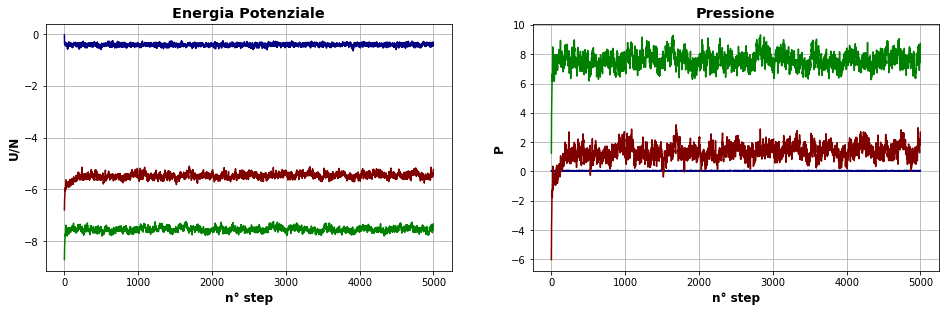

In [7]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.grid(True)
plt.title("Energia Potenziale",weight="bold",size="x-large")
plt.xlabel("n° step", weight="bold",size="large")
plt.ylabel("U/N", weight="bold",size="large")
plt.plot(u_g,color="navy")
plt.plot(u_s,color="green")
plt.plot(u_l,color="maroon")
plt.subplot(222)

plt.title("Pressione",weight="bold",size="x-large")
plt.grid(True)
plt.xlabel("n° step", weight="bold",size="large")
plt.ylabel("P ", weight="bold",size="large")
plt.plot(p_g,color="navy")
plt.plot(p_s,color="green")
plt.plot(p_l,color="maroon")


Osservando i grafici si nota come forse convenga far girare l'algoritmo per $N_{th}=250$ step senza prendere misure.

Calcoliamo ora la funzione di correlazione:

In [8]:
def autocor(x, n):  
    sigma=np.std(x)
    t_max=x.size
    corr=[]
    for dt in range(n):
        sum1=0
        sum2=0
        sum3=0
        tt=t_max-dt #è discreta, devo fare tutte le somme
        for t in range(tt):
            
            sum1+=x[t]*x[t+dt] #primo termine
            sum2+=x[t] #secondo termine
            sum3+=x[t+dt]
        corr.append((sum1/tt-sum2*sum3/(tt**2))/sigma**2)
    return corr

In [9]:
from scipy.optimize import curve_fit
def chi(t, t_c):
    return  np.exp(-t/t_c)

In [10]:
a_us=autocor(u_s,150)#lo faccio per i primi 150 step
a_ul=autocor(u_l,150)
a_ug=autocor(u_g,150)
a_ps=autocor(p_s,150)
a_pl=autocor(p_l,150)
a_pg=autocor(p_g,150)
lis1=[a_us,a_ul,a_ug]
lis2=[a_ps,a_pl,a_pg]
color=["navy","maroon","green"]
fase=["solido","liquido","gas"]

t_c solido=  11.682636205448347
t_c liquido=  25.226755113270315
t_c gas=  2.5260501549410805
t_c solido=  11.351938796448321
t_c liquido=  33.840038640653766
t_c gas=  0.9725303372729887


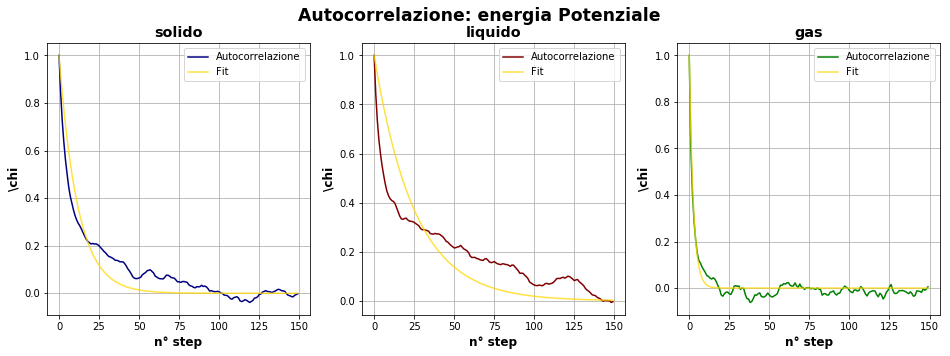

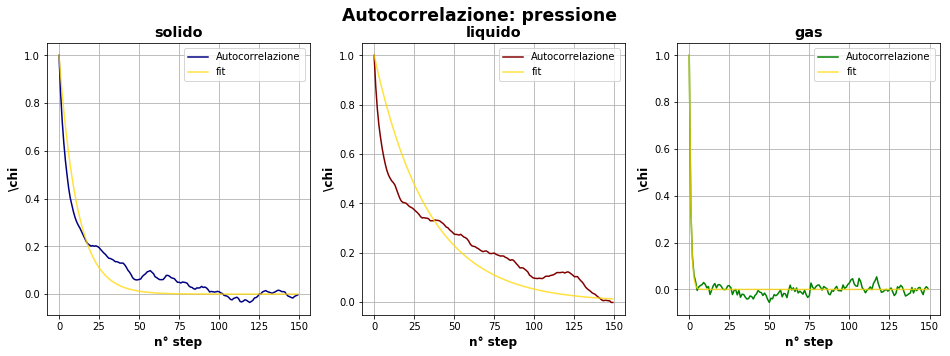

In [11]:
############################ energia potenziale
plt.figure(figsize=(16,5))
x=np.arange(150)
k=1
for i in lis1:

    plt.subplot(1,3,k)
    plt.suptitle("Autocorrelazione: energia Potenziale", weight="bold",size="xx-large")
    plt.title(fase[k-1],weight="bold",size="x-large")
    plt.xlabel("n° step", weight="bold",size="large")
    plt.ylabel("\chi", weight="bold",size="large")
    plt.plot(i,color=color[k-1],label="Autocorrelazione")
   
    #fittiamo la curva
    par, pcov = curve_fit(chi, x, i)
    plt.plot(x, chi(x, *par), color='gold', alpha=0.75,label="Fit")
    print("t_c "+(fase[k-1])+"= ",par[0])
    plt.grid(True)
    plt.legend()
    k=k+1
#####################        pressione
plt.figure(figsize=(16,5))
x=np.arange(150)
k=1
for i in lis2:

    plt.subplot(1,3,k)
    plt.grid(True)
    plt.suptitle("Autocorrelazione: pressione", weight="bold",size="xx-large")
    plt.title(fase[k-1],weight="bold",size="x-large")
    plt.xlabel("n° step", weight="bold",size="large")
    plt.ylabel("\chi", weight="bold",size="large")
    plt.plot(i,color=color[k-1],label="Autocorrelazione")
    popt, pcov = curve_fit(chi, x, i)
    plt.plot(x, chi(x, *popt), color='gold', alpha=0.75,label="fit")

    plt.legend()
    print("t_c "+(fase[k-1])+"= ",popt[0])
    k=k+1

Concludiamo pertanto che la dimensione $d$ dei blocchi deve essere superiore a:
- gas $d>23$
- liquido $d>66$
- solido $d>5$

Vogliamo ora stimare l'incertezza sul valor medio al variare del numero di blocchi $L$ (o di conseguenza al numero di step in ogni blocco).

In [2]:
phases=["solid","liquid","gas"]
tit=["Energia Potenziale","Pressione"]
potenziale=["/pot_ist.dat","/press_ist.dat"]

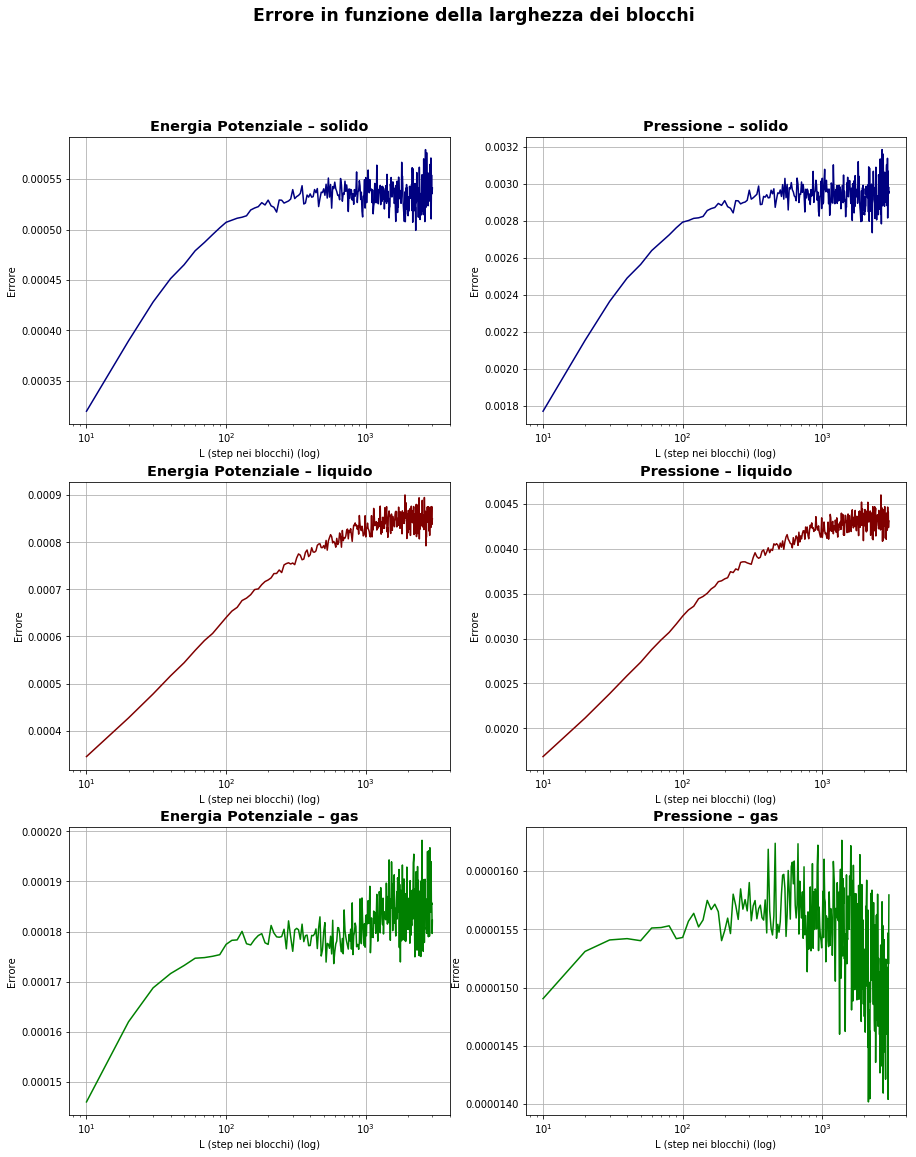

In [42]:
#funzione per calcolare l'errore nel data blocking (quella di sempre)
def error(x, x2, nstep):
    if(nstep==0): 
        return 0
    else: 
        return np.sqrt((x2-x**2)/nstep)

def data_blocking_error(x, nblk, L):
    av1=0
    av2=0
    E=0
    for n in range(nblk):
        sum1=0
        for l in range(L):
            sum1+=x[l+n*L]
        sum1 /= L
        av1=(av1*n+sum1)/(n+1)
        av2=(av2*n+sum1**2)/(n+1)
        E=error(av1, av2,n)
    return E 



L_m=10
L_M=3010
M=500000
L_step=10
L_steps=int((L_M-L_m)/L_step)

fig=plt.figure(figsize=(15, 18))
plt.suptitle("Errore in funzione della larghezza dei blocchi", size='xx-large', weight='bold')
for a in range(2):
    for i in range(3):
        plt.subplot(3,2,i*2+1+a)
        y = np.loadtxt("MonteCarlo_NVT/"+phases[i]+potenziale[a])
        error_b=[]
        x=[]
        for l in range(L_steps):
            L=L_m+l*L_step
            N=int(M/L)
            err=data_blocking_error(y,N,L)
            error_b.append(err)
            x.append(L)
        plt.plot(x, error_b, color=color[i])
        
        plt.ylabel("Errore")
        plt.xlabel('L (step nei blocchi) (log)')
        plt.xscale("log")
        plt.title(tit[a]+" – "+fase[i], size='x-large', weight='bold')
        plt.grid(True)
        
plt.show()

Osservando i grafici ne deduciamo che aumentando il numero di step per blocco oltre le seguenti soglie:
- gas $\approx 200$ step
- liquido $\approx 500$ step
- solido $\approx 500$ step

l'errore sulle grandezze smette di aumentare e diventa circa costante. Questa è da considerarsi la soglia oltre cui non ha più senso aumentare le dimensioni dei blocchi.

# Esercizio 7.4

### Funzione di distribuzione radiale

Introduciamo ora la funzione di distribuzione radiale $g(r)$: tramite essa si può studiare la distribuzione di particelle in funzione della distanza $r$ da una determinata particella, ad esempio fissiamo quella nell'origine del sistema di coordinate:
$$g(r)=\frac{1}{\rho N \Delta V}\sum_i \sum_{j \neq i}\delta \left[ |\vec{r}|-|(\vec{r}_i-\vec{r}_j)| \right]$$
con:
$$\Delta V =\frac{4 \pi}{3} \left[ (r+dr)^3-r^3 \right]$$
Nel caso dell'implementazione nell'algoritmo NVT quello che si fa è contare le particelle a distanza compresa tra due certe distanze (in una shell sferica per così dire, centrata nella particella nell'origine) e aumentare di due un istogramma. Alla fine della simulazione si normalizzerà l'istogramma con la quantità $\rho N \Delta V$.

Riportiamo ora i valori di $g(r)$ ottenuti per le tre fasi, assieme ai valori di $P$ e $U/N$ mediati per  il metodo MonteCarlo:

In [12]:
e_s,e_s_err=np.loadtxt("MonteCarlo_NVT/solid/output.epot.0",usecols=(2,3),unpack=True)
p_s,p_s_err=np.loadtxt("MonteCarlo_NVT/solid/output.pres.0",usecols=(2,3),unpack=True)

e_l,e_l_err=np.loadtxt("MonteCarlo_NVT/liquid/output.epot.0",usecols=(2,3),unpack=True)
p_l,p_l_err=np.loadtxt("MonteCarlo_NVT/liquid/output.pres.0",usecols=(2,3),unpack=True)

e_g,e_g_err=np.loadtxt("MonteCarlo_NVT/gas/output.epot.0",usecols=(2,3),unpack=True)
p_g,p_g_err=np.loadtxt("MonteCarlo_NVT/gas/output.pres.0",usecols=(2,3),unpack=True)

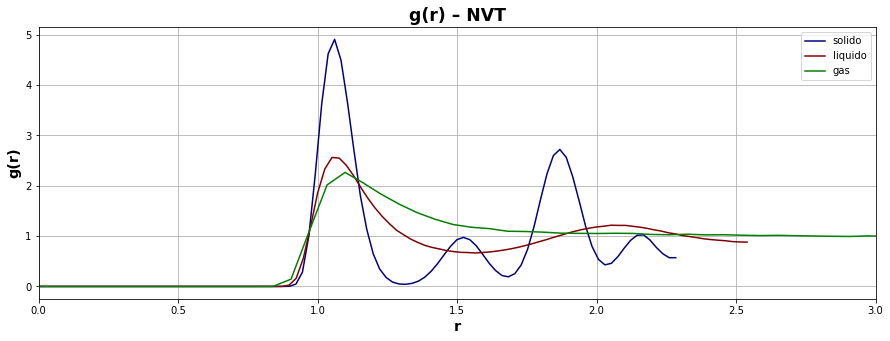

In [18]:
fig=plt.figure(figsize=(15, 5))
plt.title("g(r) – NVT", size='xx-large', weight='bold')

for i in range(3):
    x,y,err = np.loadtxt("MonteCarlo_NVT/"+phases[i]+"/output.gave.0", usecols=(1,2,3),unpack=True)
    plt.plot(x,y, color=color[i], label=fase[i])
        
        
    plt.xlabel('r',weight="bold",size="x-large")
    plt.ylabel('g(r)',weight="bold",size="x-large")
    plt.xlim(0,3)
    plt.grid(True)
    plt.legend()

plt.show()

Come si può notare la funzione $g(r)$ per tutte e tre le fasi è molto bassa per $r<1$ come ci si può aspettare. Per i liquidi presenta caratteristiche intermedie tra i solidi e i gas: per i primi infatti possiede un paio di picchi a distanze precise, per i secondi invece la funzione decresce leggermente all'aumentare di $r$ senza particolari picchi.

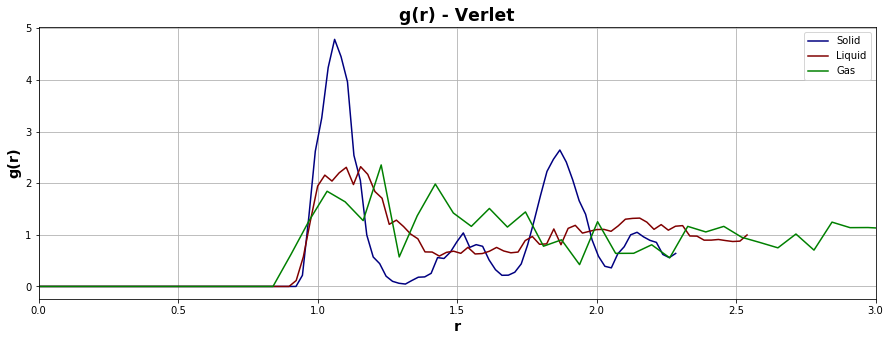

In [17]:
################## RDF g(r) ###############################################
phases=["Solid","Liquid","Gas"]
fig=plt.figure(figsize=(15, 5))
plt.title("g(r) - Verlet", size='xx-large', weight='bold')

for i in range(3):
    x,y,err = np.loadtxt("MolecularDynamics_NVE/Argon/"+phases[i]+"/output.gave.0", usecols=(1,2,3),unpack=True)
    plt.plot(x,y, color=color[i], label=phases[i])
        
    plt.xlabel('r',weight="bold",size="x-large")
    plt.ylabel('g(r)',weight="bold",size="x-large")
    plt.xlim(0,3)
    plt.grid(True)
    plt.legend()

plt.show()


Dal confronto le distribuzioni radiali paiono simili a quelle ricavate con il metodo MonteCarlo. é normale vedere  l'andamento delle curve più "spezzettato" vista la grande differenza nel numero di step fatti tra i due metodi.

Riportiamo infine energia potenziale e pressione in unità del sistema internazionale.

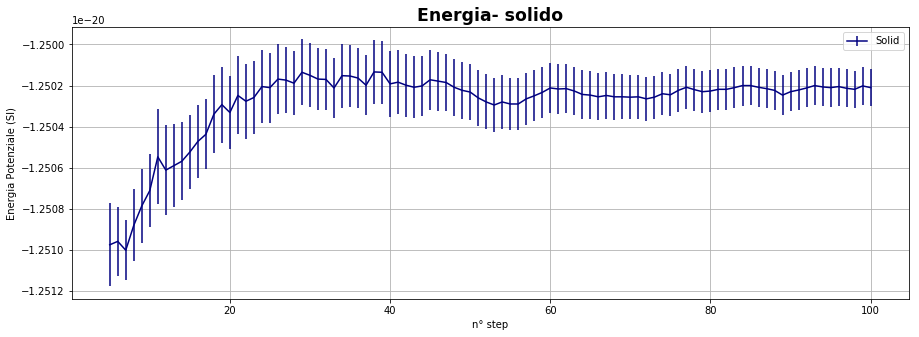

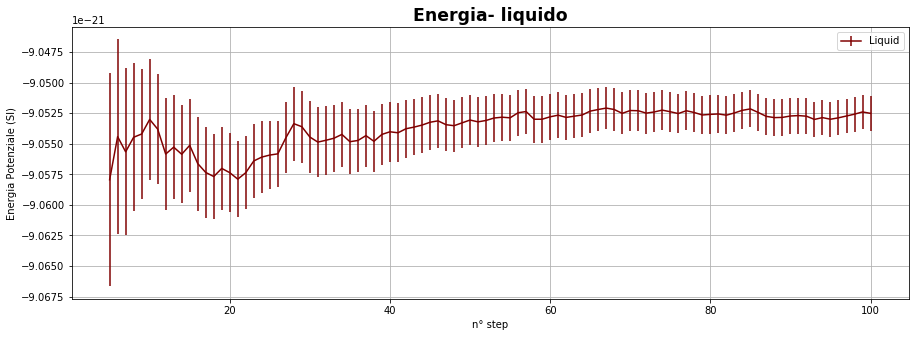

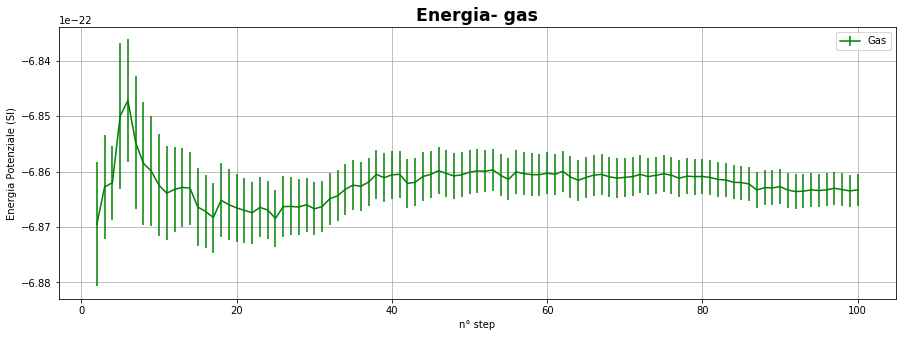

In [15]:
e=120*1.380649E-23
e_kb=120;



for i in range(3):
    fig=plt.figure(figsize=(15, 5))
    plt.title("Energia- "+fase[i], size='xx-large', weight='bold')
    x,y,err = np.loadtxt("MonteCarlo_NVT/"+phases[i]+"/output.epot.0", usecols=(0,2,3),unpack=True,skiprows=4)
    plt.errorbar(x,y*e,yerr=err*e, color=color[i], label=phases[i], ecolor=color[i])
        
    plt.xlabel('n° step')
    plt.ylabel('Energia Potenziale (SI)')
    plt.grid(True)
    plt.legend()

plt.show()

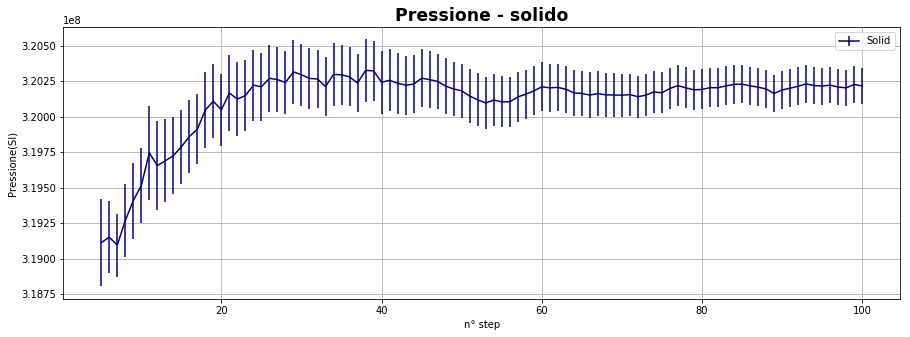

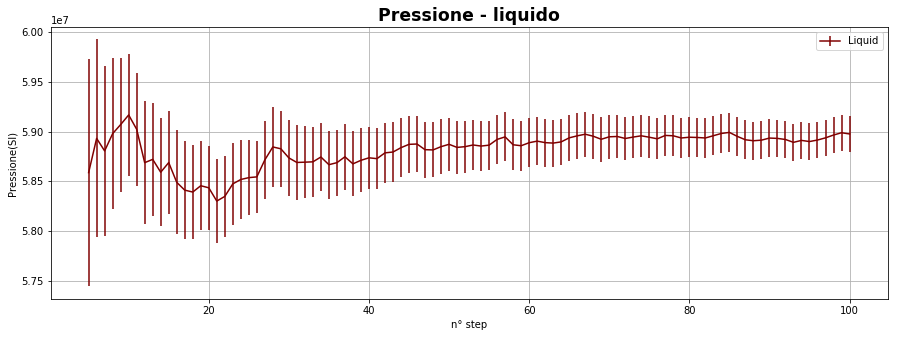

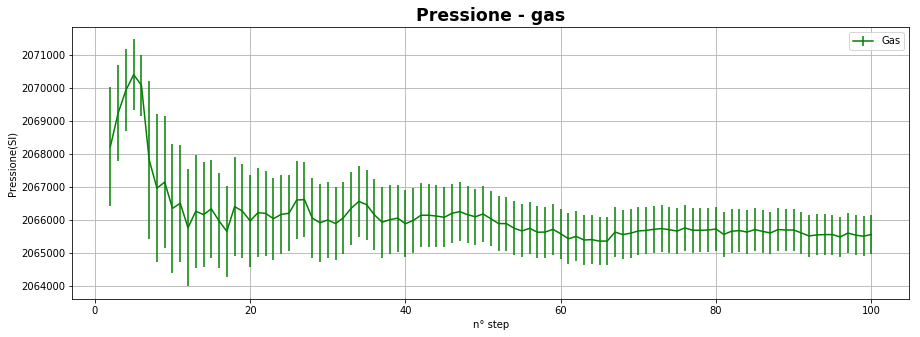

In [16]:
for i in range(3):
    fig=plt.figure(figsize=(15, 5))
    plt.title("Pressione - "+fase[i], size='xx-large', weight='bold')
    x,y,err = np.loadtxt("MonteCarlo_NVT/"+phases[i]+"/output.pres.0", usecols=(0,2,3),unpack=True,skiprows=4)
    plt.errorbar(x,y*e/(0.34*10**(-9))**3,yerr=err*e/(0.34*10**(-9))**3, color=color[i], label=phases[i], ecolor=color[i])
        
    plt.xlabel('n° step')
    plt.ylabel('Pressione(SI)')
    plt.grid(True)
    plt.legend()

plt.show()